In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

## MNIST data preparation

In [4]:
mnist_data = pd.read_csv("./data/train.csv")

In [5]:
mnist_data.shape

(42000, 785)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(mnist_data, test_size=0.1, shuffle=False)

In [8]:
train.shape

(37800, 785)

In [9]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

In [60]:
Y_test = test["label"]

# Drop 'label' column
X_test = test.drop(labels = ["label"],axis = 1) / 255.0

## DNN

In [9]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [10]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [11]:
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [12]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                             activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                             activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [13]:
with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
  loss = tf.reduce_mean(xentropy, name="loss")

In [14]:
learning_rate = 0.01

In [15]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()

In [18]:
saver = tf.train.Saver()

In [76]:
n_epochs = 100

In [77]:
batch_size = 50

In [21]:
def get_batch(df, batch_size):
    return df.sample(batch_size, axis=0)

In [41]:
test_batch = get_batch(train, 1)

In [27]:
import matplotlib

In [28]:
import matplotlib.pyplot as plt

In [42]:
test_batch

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
31072,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
digit = test_batch.drop(["label"], axis=1)

In [44]:
digit = digit.values.reshape(28,28)

In [45]:
digit.shape

(28, 28)

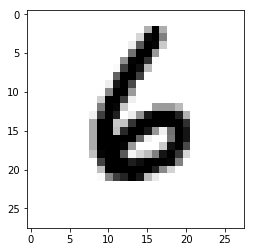

In [46]:
plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation="nearest")

In [52]:
from tensorflow.examples.tutorials.mnist import input_data

In [53]:
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [22]:
len(train)

37800

In [78]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train) // batch_size):
            batch = get_batch(train, batch_size)
#             print(batch.head)
            X_batch = batch.drop(labels = ["label"], axis=1).astype(float).values / 255.0
            Y_batch = batch.label.astype(int).values
#             X_batch, Y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: Y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: Y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test,
                                      y: Y_test})
        print(epoch, "Train accuracy:", acc_train,
             "Validation accuracy:", acc_val)
    save_path = saver.save(sess, "./dnn_model_mnist.ckpt")

0 Train accuracy: 0.8 Validation accuracy: 0.8840476
1 Train accuracy: 0.88 Validation accuracy: 0.90619045
2 Train accuracy: 0.94 Validation accuracy: 0.9154762
3 Train accuracy: 0.84 Validation accuracy: 0.9259524
4 Train accuracy: 0.96 Validation accuracy: 0.93
5 Train accuracy: 0.94 Validation accuracy: 0.93285716
6 Train accuracy: 0.88 Validation accuracy: 0.93761903
7 Train accuracy: 0.98 Validation accuracy: 0.9411905
8 Train accuracy: 0.98 Validation accuracy: 0.94095236
9 Train accuracy: 0.96 Validation accuracy: 0.94785714
10 Train accuracy: 0.94 Validation accuracy: 0.9454762
11 Train accuracy: 0.98 Validation accuracy: 0.95166665
12 Train accuracy: 0.98 Validation accuracy: 0.9538095
13 Train accuracy: 0.96 Validation accuracy: 0.95285714
14 Train accuracy: 0.98 Validation accuracy: 0.95357144
15 Train accuracy: 0.94 Validation accuracy: 0.9552381
16 Train accuracy: 0.96 Validation accuracy: 0.95690477
17 Train accuracy: 0.96 Validation accuracy: 0.9583333
18 Train accuracy

In [79]:
submit_test = pd.read_csv("./data/test.csv")

In [80]:
with tf.Session() as sess:
    saver.restore(sess, "./dnn_model_mnist.ckpt") #"my_model_final.ckpt")
    X_new_scaled = submit_test / 255.0
    Z = logits.eval(feed_dict={X: X_new_scaled})
    submit_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./dnn_model_mnist.ckpt


In [81]:
submit = {'ImageId': [i+1 for i in range(len(submit_pred))], 'Label': submit_pred}

In [82]:
submit_df = pd.DataFrame(data=submit)

In [83]:
submit_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [84]:
submit_df = pd.DataFrame(data=submit)

In [74]:
submit_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [85]:
submit_df.to_csv("dnn_predict_plain_tf_100_epochs.csv", index=False)